In [151]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [153]:
# fix random seed for reproducibility
np.random.seed(7)

In [154]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
file_path = '/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv'

In [157]:
df = pd.read_csv(file_path, parse_dates= True, index_col= 0)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


In [158]:
df.shape

(11688, 6)

In [159]:
dg = df.copy(deep = True)

In [160]:
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour

In [161]:
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,month,hour
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,1,1
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,1,4
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,1,7
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,1,10
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,1,13


In [162]:
cols_to_transform = ['air_temp', 'precip_depth_per_hour', 'station_pressure_rate', 'Vitesse du vent à 100m (m/s)', 'Rayonnement solaire global (W/m2)']

In [163]:
df.index.name = 'date'

## **LSTM Data Preparation**

We will frame the supervised learning problem as predicting the solar energy at the current hour (t) given the solar measurement and weather conditions at the prior time step.

After, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [164]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [165]:
values = dg.values

In [166]:
# ensure all data is float
values = values.astype('float32')

In [167]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [168]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [169]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis = 1, inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.000000,0.067762,0.0,0.742188,0.205197,0.000000,0.000000
2,0.000000,0.061602,0.0,0.718750,0.274194,0.000000,0.000000
3,0.000000,0.059548,0.0,0.695312,0.240143,0.000000,0.025381
4,0.025381,0.082136,0.0,0.686197,0.221326,0.008387,0.037225
5,0.037225,0.123203,0.0,0.657552,0.184588,0.099649,0.001692


We can see the 6 input variables (input series) and the 1 output variable (solar energy production at the current 3-hour slot).

In [170]:
reframed.shape

(11687, 7)

## **Define and Fit Model**

First, we must split the prepared dataset into train and test sets.

To speed up the training of the model, we will only fit the model on the first year of data, then evaluate it on the remaining 3 years of data.

In [171]:
# split into train and test sets
values = reframed.values
split = 8*365
train = values[:split, :]
test = values[split:, :]

In [172]:
print(train.shape, test.shape)

(2920, 7) (8767, 7)


Running this example prints the shape of the training and testing input and output sets with approximately 3000 3-hour slots for training and approximately 8800 3-hour slots for testing.

In [173]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2920, 1, 6) (2920,) (8767, 1, 6) (8767,)


We will define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting solar energy production. The input shape will be 1 time step with 6 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 100 training epochs with a batch size of 96 (8 3-hour slots per day * 12 months).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [174]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [175]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=96, validation_data=(test_X, test_y), verbose=0, shuffle=False)

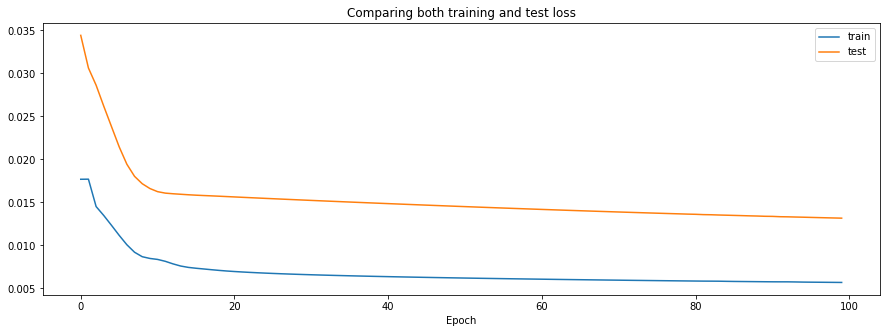

In [185]:
plt.figure(figsize = (15,5))
_ = plt.plot(history.history['loss'], label='train')
_ = plt.plot(history.history['val_loss'], label='test')

# set labels, legends and show plot
_ = plt.xlabel('Epoch')
_ = plt.legend()
_ = plt.title('Comparing both training and test loss')

## **Evaluate Model**

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected solar energy production numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [177]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [178]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [179]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [180]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 67.808


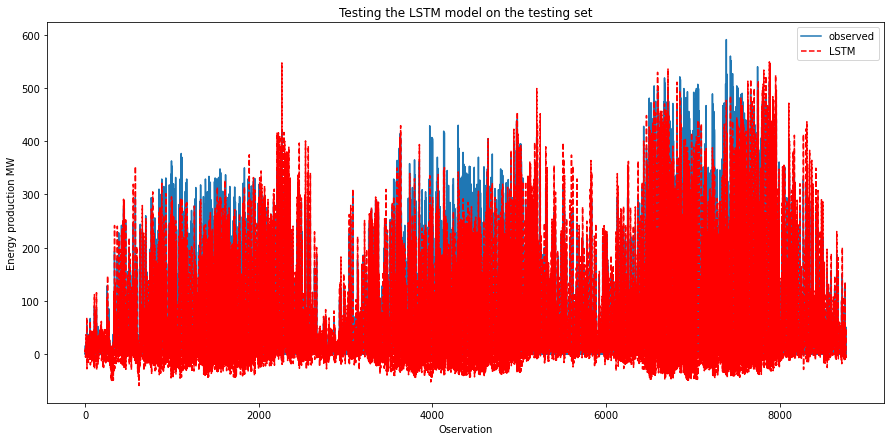

In [186]:
plt.figure(figsize = (15,7))
_ = plt.plot(inv_y, label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat, 'r--', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

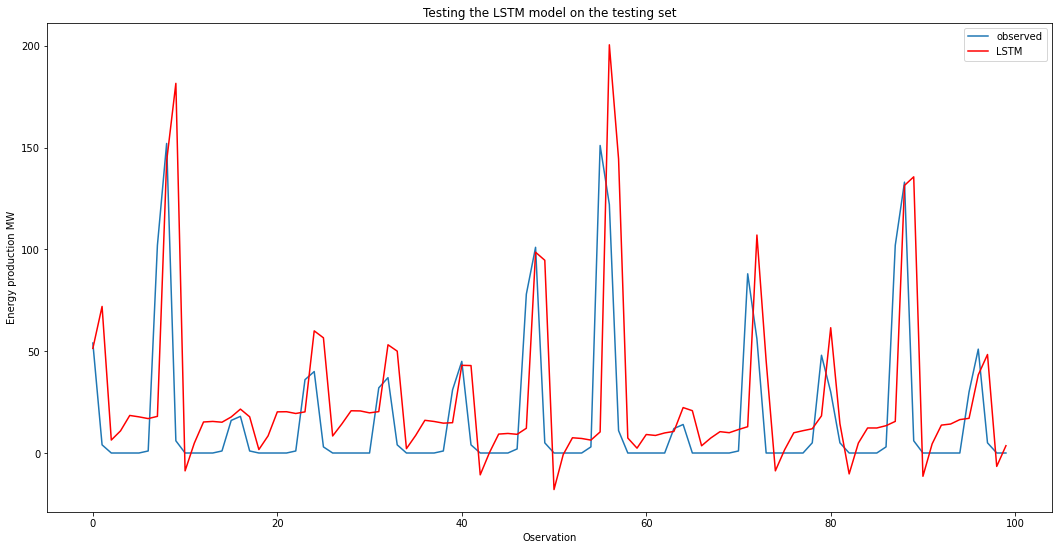

In [187]:
plt.figure(figsize = (18,9))
_ = plt.plot(inv_y[-100:], label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat[-100:], color='r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')